In [7]:
import json
from pathlib import Path
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:

# Path to your JSONL file
file_path = "/project/flame/asetlur/rc_qw4bins_ansbench_n4_t16_l16k2k_new2.jsonl"

# Each line is a JSON list, merge all into one list, then make a DataFrame from the merged list of dicts
import json

all_items = []
with open(file_path, "r") as f:
    for line in f:
        items = json.loads(line)
        for item in items:
            # If 'metadata' exists and is a dictionary, merge it into the item
            metadata = item.pop("metadata", {})
            if isinstance(metadata, dict):
                # Avoid overwriting existing keys in item when merging metadata
                for k, v in metadata.items():
                    if k not in item:
                        item[k] = v
                    else:
                        # If key collision, optionally rename metadata keys, or overwrite
                        item[f"metadata_{k}"] = v
            all_items.append(item)

df = pd.DataFrame(all_items)

print(f"Loaded {len(df)} rows")
print(f"Dataframe shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
# print(df.head())





Loaded 51200 rows
Dataframe shape: (51200, 20)
Columns: ['text', 'output_text', 'n_predicted', 'reward', 'logprobs', 'ref_logprobs', 'input_ids', 'labels', 'group_id', 'finished', 'prompt_tokens', 'output_tokens', 'visual_features', 'model_version', 'rollout_index', 'cycle_step', 'turn_type', 'turn_number', 'problem_id', 'sample_id']


In [9]:
# Filter for turn_type == "reasoning"
reasoning_df = df[df["turn_type"] == "reasoning"].copy()

# Compute 'turn' as cycle_step // 2
reasoning_df["turn"] = reasoning_df["cycle_step"] // 2

# Group by 'turn' and compute the mean reward
grouped_turns = reasoning_df.groupby("turn")["reward"].mean()

print("Average reward by turn (for turn_type == 'reasoning'):")
print(grouped_turns)


Average reward by turn (for turn_type == 'reasoning'):
turn
0     0.321250
1     0.355000
2     0.373125
3     0.379375
4     0.385000
5     0.394375
6     0.400625
7     0.403125
8     0.398750
9     0.399375
10    0.405625
11    0.400000
12    0.398125
13    0.395625
14    0.401875
15    0.402500
Name: reward, dtype: float64


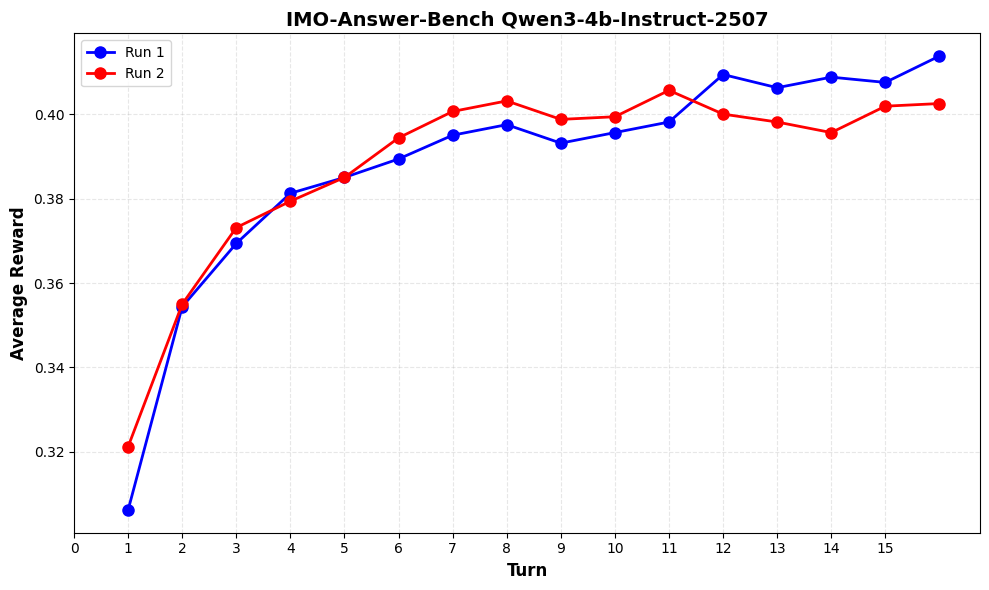

In [11]:
import matplotlib.pyplot as plt

# Data from the output
turns = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
rewards = [0.306250, 0.354375, 0.369375, 0.381250, 0.385000, 0.389375, 
           0.395000, 0.397500, 0.393125, 0.395625, 0.398125, 0.409375, 
           0.406250, 0.408750, 0.407500, 0.413750]
rewards_2 = [0.321250, 0.355000, 0.373125, 0.379375, 0.385000, 0.394375, 
           0.400625, 0.403125, 0.398750, 0.399375, 0.405625, 0.400000, 
           0.398125, 0.395625, 0.401875, 0.402500]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(turns+1, rewards, marker='o', linewidth=2, markersize=8, color='blue', label='Run 1')
plt.plot(turns+1, rewards_2, marker='o', linewidth=2, markersize=8, color='red', label='Run 2')
plt.xlabel('Turn', fontsize=12, fontweight='bold')
plt.ylabel('Average Reward', fontsize=12, fontweight='bold')
plt.title('IMO-Answer-Bench Qwen3-4b-Instruct-2507', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
plt.xticks(turns)
plt.tight_layout()
plt.show()
